<a href="https://colab.research.google.com/github/nsriniva/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [1]:
from collections import OrderedDict
from math import isclose
import zipfile 
from urllib.request import urlopen
import io

import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

# For details about the data cleanup, please see 
# https://github.com/nsriniva/DS-Unit-2-Applied-Modeling/blob/master/CleanupOnlineNewsPopularity.ipynb
# and 'The Dataset' section of
# https://nsriniva.github.io/2020-10-23-DSPT9-Unit1-BuildProject/

# Cleaned up and uploaded csv data file from 
# https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip 
# in
# https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity
# to my github repo as
# https://github.com/nsriniva/DS-Unit-2-Applied-Modeling/blob/master/OnlineNewsPopularity.csv.zip?raw=true

# The associated names file is available at
# https://raw.githubusercontent.com/nsriniva/DS-Unit-2-Applied-Modeling/master/OnlineNewsPopularity.names


onp_url = 'https://github.com/nsriniva/DS-Unit-2-Applied-Modeling/blob/master/OnlineNewsPopularity.csv.zip?raw=true'

onp_df = pd.read_csv(onp_url, compression='zip')

null_values = onp_df.isna().sum().sum()

print(f"There are {['','no'][int(null_values==0)]} invalid values in the dataset!")

# The zscore() method from the scipy.stats package is used to compute z scores 
# for the shares values. These z scores is compared against the specified  
# sigma value to generate a boolean filter array that could be used to 
# paritition the dataset based on whether the zscore is greater than the
# specified sigma.
def get_sigma_filter(df, sigma=0.5):
  z = np.abs(stats.zscore(df.shares))
  return np.where(z>sigma)[0]

# Use the boolean filter array provided by get_sigma_filter() to
# ignore entries with zscore greater than 0.5 and compute the
# median and max 'shares' values for the remaining entries.
def classification_marks(df):

  shares_info = df.drop(get_sigma_filter(df)).shares

  max = shares_info.max()
  median = shares_info.median()

  return median, max


shares_median = onp_df.shares.median()

print(shares_median)
# Use the medium(median) value to classify articles into 
# unpopular(0) and popular(1)  
onp_df['popularity'] = onp_df.shares.apply(lambda x: 0 if x < shares_median else 1)

display(onp_df.shape)

# Remove outliers
def remove_outliers(df, sigma=0.5):
  df = df.copy()
  return df.drop(get_sigma_filter(df, sigma))

onp_no_df = remove_outliers(onp_df, 0.25)

shares_median = onp_no_df.shares.median()

print(shares_median)

# Use the medium(median) value to classify articles into 
# unpopular(0) and popular(1)  
onp_no_df['popularity'] = onp_no_df.shares.apply(lambda x: 0 if x < shares_median else 1)

display(onp_no_df.shape)



# The baseline accuracy or the value we'd get by just guessing that that the
# value is always the majority class

target = 'popularity'

baseline_accuracy = onp_no_df[target].value_counts(normalize=True).max()

print(f'baseline_accuracy = {baseline_accuracy:0.4f}')

# Drop the 'shares' column used to derive 'popularity' along
# with the non predictive 'url' and 'timedelta' columns.
drop_cols = ['shares', 'url', 'timedelta']

onp_no_df = onp_no_df.drop(columns=drop_cols)
# Will use a random split of 64% Training, 16% Validation and 20% Test 

X = onp_no_df.drop(columns=target)
y = onp_no_df[target]

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,train_size=0.8, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=42)

display(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

display(y_train.value_counts(normalize=True))
baseline_accuracy = y_train.value_counts(normalize=True).max()

print(f'baseline_accuracy = {baseline_accuracy:0.4f}')


There are no invalid values in the dataset!
1400.0


(39644, 51)

1300.0


(34793, 51)

baseline_accuracy = 0.5469


(22267, 47)

(5567, 47)

(6959, 47)

(22267,)

(5567,)

(6959,)

1    0.548165
0    0.451835
Name: popularity, dtype: float64

baseline_accuracy = 0.5482


In [2]:
!pip install category_encoders

from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

# Simple model, with OrdinalEncoder for the data_channel and weekday categorical
# columns and a DecisionTreeClassifier with default parameter values.
model = make_pipeline(
  OrdinalEncoder(), 
  DecisionTreeClassifier()
)

model.fit(X_train, y_train)

display(y_train.value_counts(normalize=True))
display(y_val.value_counts(normalize=True))

training_bl = y_train.value_counts(normalize=True).max()
validation_bl = y_val.value_counts(normalize=True).max()

training_acc =  model.score(X_train, y_train)
validation_acc =  model.score(X_val, y_val)


print(f'Training Accuracy:{training_acc:0.4f}/{training_bl:0.4f}')
print(f'Validation Accuracy:{validation_acc:0.4f}/{validation_bl:0.4f}')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1    0.548165
0    0.451835
Name: popularity, dtype: float64

1    0.540327
0    0.459673
Name: popularity, dtype: float64

Training Accuracy:1.0000/0.5482
Validation Accuracy:0.5813/0.5403


In [3]:
def display_corr(df, ax):
## heatmeap to see the correlation between features. 
# Generate a mask for the upper triangle (taken from seaborn example gallery)
  df_corr = df.corr()

  mask = np.zeros_like(df_corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  sns.heatmap(df_corr, 
              annot=False,
              mask = mask,
              cmap = 'RdBu_r',
              linewidths=0.1, 
              linecolor='white',
              vmax = .9,
              ax = ax,
              square=True)
  
  ax.set_title(f'Correlations Among Features', y = 1.03,fontsize = 20);



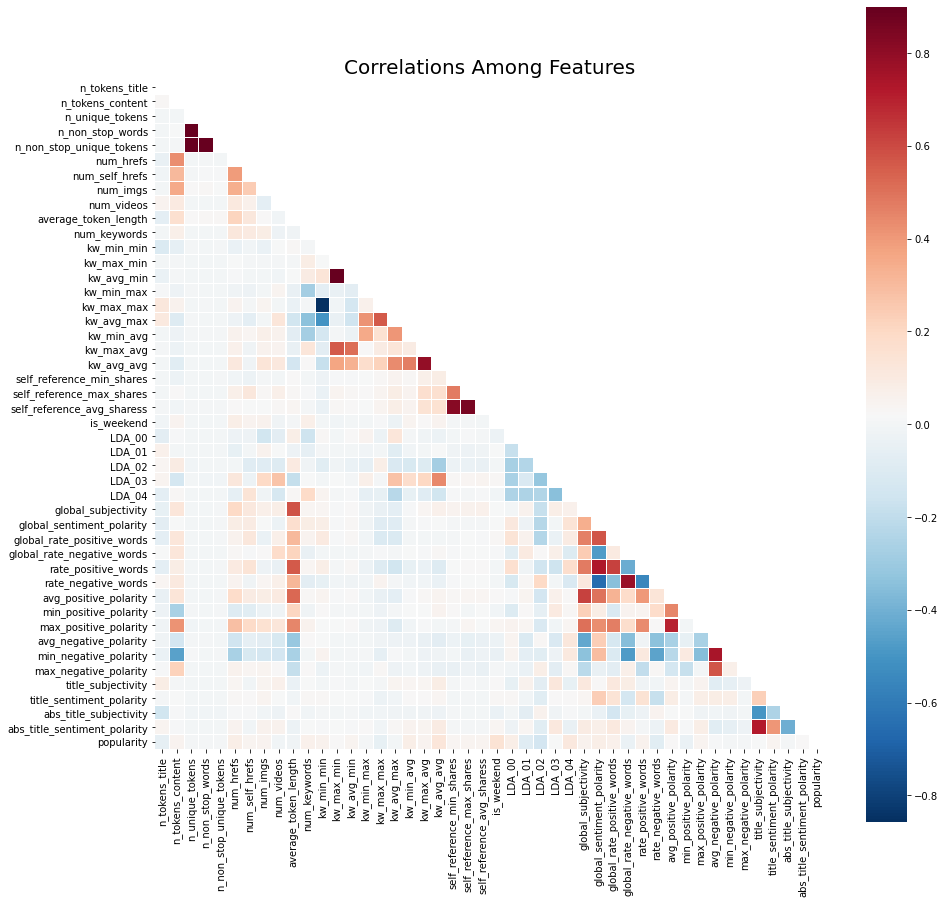

In [4]:
fig, ax = plt.subplots(1,1,figsize =(15,15))

display_corr(onp_no_df,ax)



In [5]:
!pip install eli5

transformers = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [6]:
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.0100 ± 0.0032,is_weekend
0.0089 ± 0.0070,kw_avg_avg
0.0037 ± 0.0032,LDA_03
0.0034 ± 0.0047,self_reference_min_shares
0.0033 ± 0.0040,LDA_00
0.0033 ± 0.0031,kw_max_avg
0.0030 ± 0.0016,LDA_04
0.0026 ± 0.0024,data_channel
0.0026 ± 0.0065,global_subjectivity
0.0025 ± 0.0054,kw_min_avg


In [7]:
print('Shape before removing', X_train.shape)

minimum_importance = 0 
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

print('Shape after removing ', X_train.shape)

X_val = X_val[features]




Shape before removing (22267, 47)
Shape after removing  (22267, 30)


In [8]:
pipe_elems = (
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipe = make_pipeline(
    *pipe_elems
)


# Fit on train, score on val
pipe.fit(X_train, y_train)
print('Validation Accuracy', pipe.score(X_val, y_val))


Validation Accuracy 0.6565475121250225


In [9]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1) 

)

pipeline.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.6515178731812467
